# Определение рыночной стоимости автомобилей

Сервис по продаже автомобилей с пробегом **«Не бит, не крашен»** разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В нашем распоряжении исторические данные: 
- технические характеристики, 
- комплектации и цены автомобилей. 

Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных

Для начала импортируем библиотеки, которые будем использовать в ходе исследования:

In [1]:
# импорт библиотеки pandas
import pandas as pd

# импорт библиотеки numpy
import numpy as np

# импорт библиотеки seaborn
import seaborn as sns

# импорт pyplot из библиотеки matplotlib
import matplotlib.pyplot as plt

# train_test_split из модуля sklearn.model_selection
from sklearn.model_selection import train_test_split

# импорт метрик из sklearn.metrics
from sklearn.metrics import (r2_score,
                             mean_squared_error)

# импорт StandardScaler из библиотеки
from sklearn.preprocessing import StandardScaler

# импортируем LogisticRegression  из модуля sklearn.linear_model
from sklearn.linear_model import LinearRegression

# импорт CatBoostRegressor
from catboost import (CatBoostRegressor, CatBoost)

from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

Прочитаем файл c данными: `/datasets/autos.csv`. Cохраним содержимое в соответствующей переменной:

In [2]:
# чтение файла с данными и сохранение
df_autos = pd.read_csv('/datasets/autos.csv')

Выведем размерность таблицы и ознакомимся с результатами:

In [3]:
#выведем размерность таблицы
df_autos.shape

(354369, 16)

Около **354,4 тысяч** объектов, 16 признаков в исходном датафрейме.

Применем метод **`info()`** к таблице:

In [4]:
#выведем информацию о таблице
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Из описания данных известно:

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

Что бросается в глаза:
- Очевидно, что в исходной таблице присутствуют **пропущенные значения**, с которыми предстоит разобраться. Возможные причины: скорее всего не указано пользователем.
- Стиль заголовков таблицы далёк от идеального. 
- Признаки даты и времени `DateCrawled`, `DateCreated`, `LastSeen` имеют строковый формат, что несовсем корректно. Также предстоит решить важны ли они для обучения/тестирования модели. Есть подозрение, что дата скачивания анкеты из базы, дата создания анкеты и дата последней активности пользователя могут осложнить обучение модели. Также стоит ознакомиться с диапазоном значений этих признаков.

Выведем первые несколько строк таблицы:

In [5]:
#выведем первые несколько строк таблицы
df_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Сразу видим аномалии в столбцах `RegistrationMonth` и `Power` — месяц с номером `0` и нулевая мощность двигателя у `golf`... 

С этой загадкой предстоит разобраться.

Подозрение вызывает количество фотографий, в первых строчках одни нули, проверим уникальные значения:

In [6]:
#уникальные значения столбца 'NumberOfPictures'
df_autos['NumberOfPictures'].unique()

array([0])

Для всех объектов отсутствует информация о количестве фотографий. 

Придётся удалить этот признак из рассмотрения:

In [7]:
#удаление признака - количество фотографий
df_autos = df_autos.drop(['NumberOfPictures'],axis=1)

### Вывод

По результатам предварительного знакомства с данными можно сделать следующие выводы:
- Нам доступна информация для примерно *354,4 тысяч объектов* - объявлений о продаже автомобилей с пробегом. 
- В каждом объявлении инфомрация о 16 признаках, в некоторых из них имеются пропущенные значения. 
- В признаках с датой и временем некорректный формат данных, предстоит определиться с тем насколько важны эти признаки для обучения и тестирования модели.
- В столбце месяц регистрации автомобиля обнаружено аномальное значение `0`, на что следует обратить внимание.
- Отсуствует информация о количестве фотографий, этот признак придётся удалить из рассмотрения.
- *Предварительно можно утверждать, что данных для исследования достаточно*.

## Предобработка данных

На стадии предобработки данных выполним следующие операции:
- изменим названия столбцов,
- изменим тип данных,
- проверим явные дубликаты,
- заполним пропуски,
- проверим неявные дубликаты,
- проверим непрерывные и дискретные числовые признаки на аномальные значения,
- проверим численные признаки на мультиколлинеарность.

### Изменение названий столбцов (признаков)

Для добства дальнейшей работы приведём названия столбцов (признаков) к хорошему стилю.

Сохраняем текущие названия столбцов в отдельный список:

In [8]:
#сохраняем старые названия столбцов в отдельный массив
df_autos_old_columns = list(df_autos.columns)

Выведем содержимое списка на экран:

In [9]:
#выведим содержимое списка
df_autos_old_columns

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'DateCreated',
 'PostalCode',
 'LastSeen']

С помощью цикла и инструмента `isupper()` приведем названия признаков к хорошему стилю и сохраним в новом списке `df_autos_new_columns`:

In [10]:
# новый список (пока что пустой)
df_autos_new_columns = []

# запускаем цикл по старым заголовкам признаков
for name in df_autos_old_columns:
    
    # сразу приводим первую букву к нижнему регистру (мы знаем, что они все большие)
    result = name[0].lower()
    
    # запускаем цикл по буквам каждого заголовка
    for letter in name[1:]:
        
        # проверяем большая или маленькая буква нам встретилась
        if letter.isupper():
            
            # если имеем дело с большой буквой, то приводим её 
            # к нижнему регистру и ставим перед ней "змею"
            result += f'_{letter.lower()}'
            
        else:
            #е сли большой буквы нет, то оставляем всё без изменений и идём дальше
            result += letter
            
    # добавляем преобразовынный заголовок в новый список    
    df_autos_new_columns.append(result)
        
# выводим на экран заголовки с изменениями
df_autos_new_columns

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'postal_code',
 'last_seen']

Итак, список новых заголовков готов. 

Теперь **попробуем безопасно** изменить названия в исходном датафрейме с помощью цикла и функции `rename()`:

In [11]:
# переименование столбцов
for (name_new, name_old) in zip(df_autos_new_columns, df_autos_old_columns):
    df_autos = df_autos.rename(columns={name_old: name_new})

Проверим результат:

In [12]:
# для удобства выводим заголовки столбцов в виде списка
list(df_autos.columns)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'postal_code',
 'last_seen']

Это успех - все названия заголовков изменены корректно.

### Изменение формата даты и времени:

Выведем первые несколько строк всех признаков, связанных с датой и временем:

In [13]:
#выводим первые строки признаков, связанных с датой и временем
df_autos[['date_crawled',
          'date_created',
          'last_seen']].head()

,date_crawled,date_created,last_seen
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21


Мы видим структуру даты и времени, значит можем применить функцию  `pd.to_datetime`:

In [14]:
#меняем формат даты и времени с помощью `pd.to_datetime`
for column in ['date_crawled',
               'date_created',
               'last_seen']:
    df_autos[column] = pd.to_datetime(df_autos[column],
                                      format='%Y-%m-%d %H:%M:%S')

Сделаем проверку с помощью метода `info()`:

In [15]:
#вывод информации о столбцах с датой и временем
df_autos[['date_crawled',
          'date_created',
          'last_seen']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_crawled  354369 non-null  datetime64[ns]
 1   date_created  354369 non-null  datetime64[ns]
 2   last_seen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


Это успех, переходим к следующему шагу.

### Проверка явных дубликатов

Проверим наличие явных дубликатов с помощью метода `duplicated()`:

In [16]:
# проверяем наличие явных дубликатов
df_autos.duplicated().sum()

4

Явные дубликаты есть, но ничтожно мало. Удалить их достаточно просто, поэтому сдлаем это не откладывая с помощью метода `drop_duplicates()` и не забудем про `reset_index()`:

In [17]:
# удаляем явные дубликаты
df_autos = df_autos.drop_duplicates().reset_index(drop=True)

Проверим результат удаления:

In [18]:
# проверяем наличие явных дубликатов
df_autos.duplicated().sum()

0

In [19]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  not_repaired        283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  postal_code         354365 no

Удаление явных дубликатов выполнено успешно.

### Заполнение пропусков 

Заполняя пропуски параллельно будем проверять наличие неявных дубликатов, так как будем анализировать содержание признаков и принимать решение о том чем заменить в них пропущенные значения.

Для начала выведем рейтинг пропущенных значений в столбцах, отсортировав его по убыванию. 

Для этого используем команду `df.isna().mean().sort_values(ascending=False)`, где df - рассматриваемый датафрем.

In [20]:
# выводим долю пропущенных значений в каждом из признаков
df_autos.isna().mean().sort_values(ascending=False)

not_repaired          0.200793
vehicle_type          0.105795
fuel_type             0.092828
gearbox               0.055968
model                 0.055607
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Пропущенные значения в **5 признаках**, причем везде не менее 5%: от 5% до 20%. 

Все признаки с прпоусками **строкового типа**.

Причина отсуствия значений точно неизвестна, но скорее всего - не указано пользователем. 

Избавляться от такого количества данных нет желания. Решение о том, чем заполнить пропуски примем на примере факта ремонта автомобиля.

Выведем долю каждого из уникальных значений, включая пропущенные:

In [21]:
#выводим долю уникальных значений столбца 'not_repaired', включая прпоущенные
df_autos['not_repaired'].value_counts(normalize=True, 
                                      dropna=False)

no     0.697467
NaN    0.200793
yes    0.101740
Name: not_repaired, dtype: float64

Всего два значения `yes` или `no`.

Очевидно, что мы имеем дело со скошенным датафреймом: количество машин с ремонтом - около 10% из всех, 70% - не были в ремонте.

Здесь можно рассуждать следующим образом. Нам точно неизвестно была машина в ремонте или нет. Мы можем заменить на наиболее часто встречающееся значение - `no`. Но тогда мы исказим результат, ведь какая-то часть автомобилей из 20% была в ремонте, об этом говорит ЦПТ: выборка 20% из 100% ведёт себя также как и 100%. 

Если случайным образом раскидать в неизвестных 20% значения `yes` и `no` в соотношении 12,5% и 87,5%, тогда мы сохраним пропорции такими же как в известных нам 80% значений. Но это тоже будет догадка: что-то угадаем, что-то нет.

Получается, чтобы угадать, по-хорошему, нужно сделать модель, которая будет предсказывать была машина в ремонте или нет. Но так как это не приведёт к 100% точности, а также не является задачей проекта, то поступим проще.

**Присвоим всем пропущенным значениям статус: `unknown`**.

Аналогичные рассуждения применимы и для других признаков с пропущенными значениями: 
- `vehicle_type` - мы не знаем тип кузова, но могли бы угадать по другим признакам, но 100% точности не достигнуть, 
- `fuel_type` - тип топлива,
- `gearbox` - коробка передач,
- `model` - модель.

Заполняем пропуски с помощью метода `fillna`:

In [22]:
df_autos = df_autos.fillna('unknown')

Проверяем результат:

In [23]:
# выводим долю пропущенных значений в каждом из признаков
df_autos.isna().mean().sort_values(ascending=False)

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
date_created          0.0
postal_code           0.0
last_seen             0.0
dtype: float64

Пропуски успешно заполнены, идём дальше.

### Проверка неявных дубликатов

Подробнее познакомимся с признаками и заодно проверим неявные дубликаты.

#### `not_repaired`


Признак **`not_repaired`**. В нём содержится информация о том *была машина в ремонте или нет*. Известно, что покупатель как правило интересуется этой информацией: если машина восстановленная, то должна быть ниже в цене.

Посмотрим уникальные значения этого признака:

In [24]:
#выводим долю уникальных значений столбца 'not_repaired', включая прпоущенные
df_autos['not_repaired'].value_counts(normalize=True, 
                                      dropna=False)

no         0.697467
unknown    0.200793
yes        0.101740
Name: not_repaired, dtype: float64

Неявные дубликаты отсутствуют, только "да", "нет" и "не знаю".

#### `vehicle_type`

**`vehicle_type`** содержит информацию о типе автомобильного кузова:

In [25]:
#выводим долю уникальных значений, включая пропущенные
df_autos['vehicle_type'].value_counts(normalize=True, 
                                      dropna=False)

sedan          0.258087
small          0.225276
wagon          0.183892
unknown        0.105795
bus            0.081202
convertible    0.057012
coupe          0.045606
suv            0.033852
other          0.009279
Name: vehicle_type, dtype: float64

Неявные дубликаты отсутствуют. Есть значение `other`, но вероятно оно указано пользователем при размещении объявления. Поэтому относить пропущенные значения к `other` было бы несовсем корректно.

#### `fuel_type`

**`fuel_type`** - тип топлива:

In [26]:
#выводим долю уникальных значений, включая пропущенные
df_autos['fuel_type'].value_counts(normalize=True, 
                                   dropna=False)

petrol      0.610526
gasoline    0.278580
unknown     0.092828
lpg         0.014985
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: fuel_type, dtype: float64

`lpg` и `cng` не вызывают подозрений:
- `lpg` - сжиженная газовая смесь пропана и бутана
- `cng` - сжиженный природный газ



Подозрение вызывает `petrol` и `gasoline`. В некоторых странах под этими терминами подразумевается одно и то же - бензин. Но так как дополнительной информации нет, то считаем, что речь идёт об одинаковых видах топлива, но неявных дубликатов нет. В идеале нужно проперить как проще для модели: с учетом разных названий и без. Но по факту лучше избежать этой ошибки на стадии заполнения информации в анкете.

#### `gearbox`

**`gearbox`** - коробка передач:

In [27]:
#выводим долю уникальных значений, включая пропущенные
df_autos['gearbox'].value_counts(normalize=True, 
                                 dropna=False)

manual     0.756985
auto       0.187047
unknown    0.055968
Name: gearbox, dtype: float64

Автомат или ручная - как и должно быть (если не выделяем роботизированную коробку). Неизвестные позиции тоже присутствуют.

Ручная коробка популярнее в данном наборе информации.

#### `brand`

**`brand`** - брэнд:

In [28]:
#выводим долю уникальных значений, включая пропущенные
df_autos['brand'].value_counts(normalize=True, 
                               dropna=False)

volkswagen        0.217324
opel              0.112683
bmw               0.104169
mercedes_benz     0.090427
audi              0.083123
ford              0.071054
renault           0.050589
peugeot           0.031036
fiat              0.027212
seat              0.019491
mazda             0.015845
skoda             0.015521
smart             0.014804
citroen           0.014527
nissan            0.013943
toyota            0.012998
hyundai           0.010122
sonstige_autos    0.009521
volvo             0.009058
mini              0.009036
mitsubishi        0.008528
honda             0.007949
kia               0.006956
suzuki            0.006553
alfa_romeo        0.006530
chevrolet         0.004950
chrysler          0.004061
dacia             0.002540
daihatsu          0.002274
subaru            0.002150
porsche           0.002139
jeep              0.001910
trabant           0.001662
land_rover        0.001538
daewoo            0.001529
saab              0.001484
jaguar            0.001425
r

Отечественный автопром в меньшинстве. Невоодушевляющий факт. Явно данные не из России, потому что `Trabant`'ов больше, чем Лады.

Для удобства проверки дубликатов сделаем сортировку по алфавиту:

In [29]:
#сортируем уникальные значения столбца 'brand' в алфавитном порядке
pd.Series((df_autos['brand'].unique())).sort_values().reset_index(drop=True)

0         alfa_romeo
1               audi
2                bmw
3          chevrolet
4           chrysler
5            citroen
6              dacia
7             daewoo
8           daihatsu
9               fiat
10              ford
11             honda
12           hyundai
13            jaguar
14              jeep
15               kia
16              lada
17            lancia
18        land_rover
19             mazda
20     mercedes_benz
21              mini
22        mitsubishi
23            nissan
24              opel
25           peugeot
26           porsche
27           renault
28             rover
29              saab
30              seat
31             skoda
32             smart
33    sonstige_autos
34            subaru
35            suzuki
36            toyota
37           trabant
38        volkswagen
39             volvo
dtype: object

Неявные дубликаты отсутствуют - подтверждено визуально.

#### `model`

**`model`** - модель, ознакомимся с уникальными значениями. Для удобства отсортируем их в алфавитном порядке:

In [30]:
# уникальные значения столбца 'model'
models_array = df_autos['model'].unique()

# сортируем по алфавиту
models_array.sort()

# выводим на экран
models_array

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Общее количество моделей:

In [31]:
#размерность массива с моделями
len(models_array)

251

**251** модель. И, похоже, есть один неявный дубликат: `range_rover` и `rangerover`.

Посмотрим какое количество объектов с названием модели `range_rover`:

In [32]:
# количество объектов, имеющих модель 'range_rover'
df_autos[df_autos['model']=='range_rover']['model'].count()

77

77 позиций. Посмотрим кто производит эти автомобили:

In [33]:
#производители объектов с моделью 'range_rover'
df_autos[df_autos['model']=='range_rover']['brand'].value_counts()

land_rover    77
Name: brand, dtype: int64

Исключительно `land_rover`. При этом всего машин производиетля `land_rover`:

In [34]:
#общее количество объектов производителя `land_rover`
df_autos[df_autos['brand']=='land_rover']['brand'].count()

545

545 автомобилей из около 350 тыс. Может показаться немного, но мы помним, что это автомобиль высокого класса. Для обучения модели информация об этом производителе будет важна.

Проверим количество неявных дубликатов:

In [35]:
# количество объектов, имеющих модель 'rangerover'
df_autos[df_autos['model']=='rangerover']['model'].count()

4

Производитель:

In [36]:
#производители объектов с моделью 'rangerover'
df_autos[df_autos['model']=='rangerover']['brand'].value_counts()

rover    4
Name: brand, dtype: int64

Видим, что производитель другой. В настоящее время автомобили под маркой `rover` не выпускаются. Возможно, что это старые автомобили, проверим:

In [37]:
#годы регистрации автомобилей с моделью 'rangerover'
df_autos[df_autos['model']=='rangerover']['registration_year'].value_counts()

2017    1
1996    1
1998    1
2007    1
Name: registration_year, dtype: int64

Некоторые уже точно можно считать старыми, а некоторые нет.
Посмотрим пробег:

In [38]:
# пробег автомобилей модели 'rangerover'
df_autos[df_autos['model']=='rangerover']['kilometer'].value_counts()

150000    4
Name: kilometer, dtype: int64

150 тыс. км. пробег нельзя назвать огромным.
Получается, что скорее всего `rangerover` и `range_rover` не являются неявными дубликатами, так как отличается брэнд.
учтем, что позиций `rangerover` очень мало, они не должны повлиять на обучение.

Считаем, что на этом проверка неявных дубликатов закончена.

### Проверка непрерывных признаков на аномальные значения

#### Признаки даты и времени

Следующие признаки имеют формат даты и времени:
- `date_crawled` - дата скачивания анкеты из базы, 
- `date_created` - дата создания анкеты, 
- `last_seen` - дата последней активности пользователя.

Посмотрим для них минимум и максимум:

In [39]:
#минимальная дата для 'date_crawled'
df_autos['date_crawled'].min()

Timestamp('2016-03-05 14:06:22')

In [40]:
#максимальная дата для 'date_crawled'
df_autos['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Анкеты скачивали из базы около **1 мес**. Аномалий нет.

Дата создания анкеты:

In [41]:
#минимальная дата для 'date_created'
df_autos['date_created'].min()

Timestamp('2014-03-10 00:00:00')

In [42]:
#максимальная дата для 'date_created'
df_autos['date_created'].max()

Timestamp('2016-04-07 00:00:00')

В нашем распоряжении анкеты за период **около 2 лет**.

Дата последней активности пользователя:

In [43]:
#минимальная дата для 'last_seen'
df_autos['last_seen'].min()

Timestamp('2016-03-05 14:15:08')

In [44]:
#максимальная дата для 'last_seen'
df_autos['last_seen'].max()

Timestamp('2016-04-07 14:58:51')

Период дат активности совпадает с периодом дат выгрузки объявлений. Противоречий на первый взгляд нет.

#### `registration_year`, `registration_month`

`registration_year` - год регистрации автомобиля, `registration_month` - месяц регистрации автомобиля.

Провервым делом проверим месяц регистрации на аномальные значения:

In [45]:
#выводим на экран уникальные значения столбца 'registration_month' в порядке возрастания
pd.Series(df_autos['registration_month'].unique()).sort_values()

0      0
10     1
8      2
9      3
11     4
1      5
3      6
4      7
2      8
12     9
5     10
7     11
6     12
dtype: int64

Мы видим аномальное значение месяца - `0`. Причина его появления - либо ошибка, либо не указан при заполнении анкеты. 

Посмотрим сколько всего значений с таким месяцем:

In [46]:
#выводим количество каждого из уникальных значений столбца 'registration_month'
df_autos['registration_month'].value_counts()

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: registration_month, dtype: int64

Объектов с месяцем `0` больше всего. Вероятно, пользователь считает более важным признак год регистрации и поэтому не указывает месяц. *Примем следующее решение*: не будем удалять объекты с месяцем `0`, при обучении и тестировании модели будем использовать **только год регистрации**, так как месяц регистрации менее важен чем год и текущий пробег машины (сделаем такое предположение).

Проверим какие значения в признаке **год регистрации**.

Мы знаем, что объявления выгружали в период с `2016-03-05 14:06:22` до `2016-04-07 14:36:58`. Соответственно, объявления, в которых **год и месяц регистрации автомобиля** *будут превышать* **год и месяц выгрузки объявления** **можно считать аномальными**. Уберем такие объявления из рассмотрения, чтобы они не научили нашу модель "плохому".

Сначала ознакомимся с уникальными значениями `registration_year`, которые превышают 2016 год (пока что без учета месяца), чтобы убедиться в наличии аномалий:

In [47]:
#выводим количество уникальных значений 'registration_year', в которых год превышает 2016
df_autos[df_autos['registration_year']>2016]['registration_year'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
2500        4
7000        4
4000        3
9000        3
8000        2
5555        2
2222        2
2800        2
4500        2
5911        2
3700        1
3500        1
2900        1
8500        1
4100        1
9450        1
5900        1
6500        1
7100        1
5300        1
7800        1
8888        1
8200        1
9996        1
8455        1
2290        1
2066        1
5600        1
4800        1
3800        1
3200        1
9229        1
2200        1
7500        1
Name: registration_year, dtype: int64

Всего объектов, в которых год регистрации автомобиля превышает год выгрузки базы данных ("машины из будущего"):

In [48]:
#количество объектов, в которых год регистрации авто превышает год выгрузки базы данных
df_autos[df_autos['registration_year']>2016]['registration_year'].count()

14530

14530 шт. Но условие превышения периода выгрузки немного сложнее, ведь в нашем распоряжении есть месяц регистрации. 

Тогда, используя *бритву Оккама*, можем записать дополнительное условие: если год выгрузки объявления совпадает с годом регистрации автомобиля, то давайте проверим месяц регистрации, тогда, если он превышает дату скачивания анкеты из базы, то мы имеем дело с "автомобилем будущего".

Запишем это условие с помощью атрибутов `dt.year` и `dt.month`:

In [49]:
(
    #объекты, в которых год регистрации авто превышает год скачивания анкеты
    df_autos[(df_autos['registration_year']>df_autos['date_crawled'].dt.year)|
             
             #доп. условие - если год совпадает
             ((df_autos['registration_year']==df_autos['date_crawled'].dt.year)&
             
              #проверяем месяц
              (df_autos['registration_month']>df_autos['date_crawled'].dt.month))]
    
    #считаем сколько всего аномалий
    .count()
    
    #по этому столбцу
    ['registration_year']
)

19759

Количество аномалий увеличилось.

Посмотрим сколько всего аномальных по дате регистрации автомобиля объектов. Для этого сначала выведем общее количество объектов, затем разделим на него количество аномалий:

In [50]:
#количество объектов
print('Количество объектов всего:', df_autos.shape[0])

Количество объектов всего: 354365


In [51]:
#процент аномальных объектов по дате регистрации автомобиля
print('Процент аномальных объектов по дате регистрации автомобиля:', round(19759/354365*100,2) , '%')

Процент аномальных объектов по дате регистрации автомобиля: 5.58 %


Около **5.58%** объявлений, в которых дата регистрации авто превышает дату выгрузки объявления из базы.
Избавимся от этих строк, чтобы не загрузить в модель "мусор".

Сделаем это следующим образом:

In [52]:
            #объекты, в которых год регистрации авто НЕ превышает год скачивания анкеты
df_autos = (df_autos[(df_autos['registration_year']<df_autos['date_crawled'].dt.year)|
                     
                     #доп. условие - если год совпадает
                     ((df_autos['registration_year']==df_autos['date_crawled'].dt.year)&
                      
                      #проверяем месяц, берем только те в тоторых месяц регистрации `<=`
                      (df_autos['registration_month']<=df_autos['date_crawled'].dt.month))]
           
           ).reset_index(drop=True)

Смотрим как изменилось общее количество объектов:

In [53]:
#количество объектов после отсечения аномальных объектов
df_autos.shape[0]

334606

Сделаем проверку - вычтем из общего коилчества до фильтрации количество объектов после фильтрации:

In [54]:
354365-334606

19759

Было *19579* аномалий, ровно на столько уменьшилось количество рассматриваемых объектов.

#### `power`

Ознакомимся с характеристикой выборки признака `power`:

In [55]:
#характеристика выборки признака 'power'
df_autos['power'].describe()

count    334606.000000
mean        111.388555
std         183.822995
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

В среднем 111 л.с., но стандартное отклонение 183 л.с, хотя медиана близка к среднему. Значит есть аномальные значения - выбросы.

Построим "ящик с усами" для мощности двигателя. Так как будем вызывать команду построения **"ящика с усами"** несколько раз, то для удобства создадим фнкцию:

In [56]:
def box_plot_graph(name):
    #размер графика
    plt.figure(figsize=(6,6))
    
    sns.boxplot(data=df_autos[name])
    
    #название графика
    plt.title('Диаграмма размаха для '+name, fontsize=16)
    
    #подписи осей
    plt.ylabel(name, fontsize=16)
    
    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    
    #отображение сетки
    plt.grid()
    plt.show()

Также запишем в виде функции график **частоты встречающихся значений (гистограммы)** для выбранного признака:

In [57]:
def hist_plot_graph(name):   
    #размер графика
    plt.figure(figsize=(10,6))
    
    sns.histplot(df_autos[name],
                 label=name)

    #название графика
    plt.title('Гистограмма для признака: '+name, fontsize=16 )
    
    #подписи осей
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Частота', fontsize=16)
    
    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    
    plt.legend(fontsize=14)
    
    #отображение сетки
    plt.grid()
    plt.show()

Вызываем функцию графика ящика с усами для признака `power`:

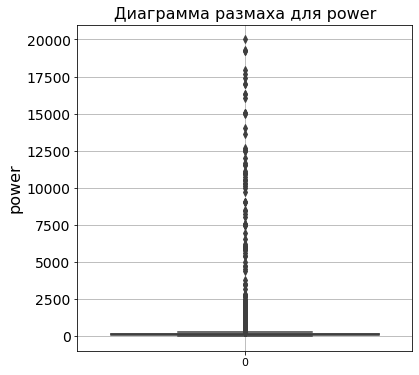

In [58]:
box_plot_graph("power")

Мы видим, что аномально большие значения "всхлопнули" ящик адекватных.

Автомобилей с мощностью двигателя выше 1000 л.с. не так много в мире, известны отдельные экземпляры на 2000 л.с. (например, Lotus Evija).

Возникает вопрос: какое количество объектов в исходном датафрейме имеют мощность двигателя выше 2500 л.с.?

Ответ:

In [59]:
#количество объектов с мощностью двигателя выше 2500
df_autos[df_autos['power']>2500]['power'].count()

86

Всего 86 объектов. Таким количеством можно пренебречь.

Посмотрим какие это модели:

In [60]:
#модели автомобилей с мощностью двигателя выше 2500 л.с.
df_autos[df_autos['power']>2500]['model'].value_counts()

unknown        8
polo           7
corsa          6
5er            5
other          5
e_klasse       3
golf           3
transporter    3
3er            2
agila          2
fortwo         2
80             2
passat         2
focus          2
c_klasse       2
a4             2
a3             2
astra          2
fiesta         2
caddy          1
kangoo         1
c_max          1
spark          1
a6             1
cooper         1
1er            1
megane         1
clk            1
up             1
s_klasse       1
berlingo       1
147            1
twingo         1
clio           1
carisma        1
galaxy         1
aygo           1
ibiza          1
omega          1
zafira         1
seicento       1
lupo           1
ceed           1
Name: model, dtype: int64

`kangoo` и `polo` с мощностью двигателя выше 2500 л.с. Это сложно себе представить. Похоже исходные данные имеют ошибки. Попробуем опустить планку, количество авто с мощностью более 500 л.с.:

In [61]:
#количество объектов с мощностью двигателя выше 2500
df_autos[df_autos['power']>500]['model'].count()

420

В процентах от общего количества объектов:

In [62]:
round(420/df_autos.shape[0]*100,2)

0.13

Менее 0,5% значений с мощностью двигателя **более** 500 л.с. 

Принимаем решение сделать фильтрацию по данному признаку:

In [63]:
# делаем фильтрацию по признаку 'power' - отсекаем объекты, 
# в которых мощность двигателя превышает 500 л.с.
df_autos = df_autos[df_autos['power']<500].reset_index(drop=True)

Смотрим, как изменилась характеристика выборки:

In [64]:
#характеристика выборки столбца 'power'
df_autos['power'].describe()

count    334152.000000
mean        107.867806
std          62.706460
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         490.000000
Name: power, dtype: float64

Стандартное отклонение снизилось, медиана и среднее стали ближе.

Повторим "ящик с усами":

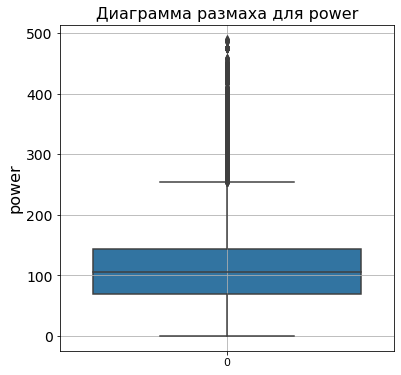

In [65]:
box_plot_graph("power")

Теперь выборка более наглядна. Обратимся к гистограмме:

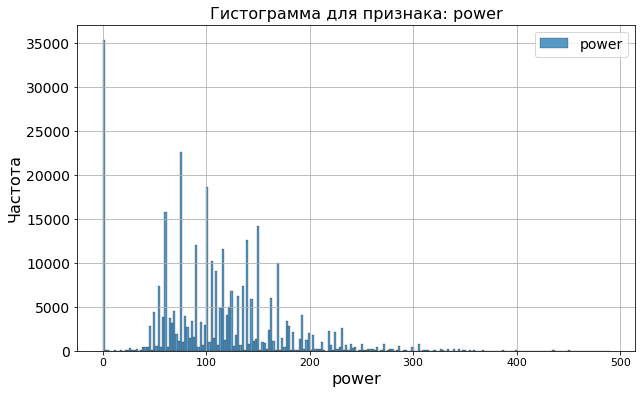

In [66]:
hist_plot_graph("power")

Дополнительно построим плотность распределения для признака `power`. Для этого запишем функцию:

In [67]:
def kde_plot_graph(name):
    #размер графика
    plt.figure(figsize=(10,6))
    
    sns.kdeplot(df_autos[name])
    
    #название графика
    plt.title("Плотность распределения для признака ' " +name+" ' ", fontsize=16 )
    
    #подписи осей
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Плотность распределения', fontsize=16)
    
    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    
    #отображение сетки
    plt.grid()
    plt.show()

Теперь построим график: 

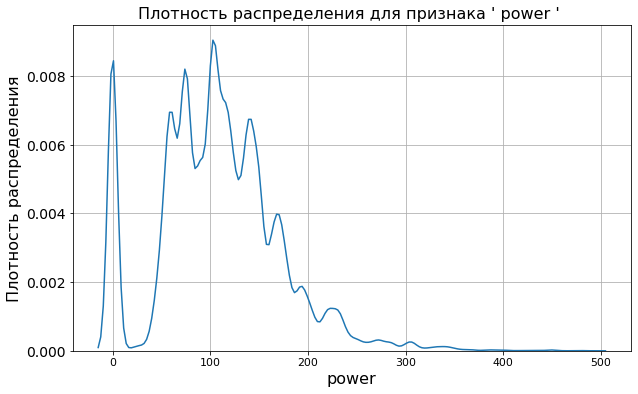

In [68]:
kde_plot_graph('power')

Обнаруживаем ещё одну проблему - есть значения `0`.

Выведем их количество:

In [69]:
#количество объектов с нулевым значением мощности
df_autos[df_autos['power']==0]['power'].count()

35231

Эта проблема более существенна, чем аномально большие значения, потому что мы обнаружили высокий процент объектов от общего количества:

In [70]:
#вычисляем процент от общего количества
round(35231/df_autos.shape[0],2)*100

11.0

Около 11% данных.

Как избавиться от нулей и стоит ли это делать?

Посмотрим какие значения мощность двигателя принимает в среднем (и не только) для каждой модели с помощью `groupby`:

In [71]:
#для каждой модели авто смотрим некоторые характеристики мощности двигателя
(
    df_autos[df_autos['power']>0][['model','power']]
    .groupby('model')
    .agg(['count','min','max','median','mean'])
    .head(10)
)

power                             
        count  min  max median        mean
model                                     
100       377   55  280  133.0  137.251989
145        35   66  227  103.0  112.228571
147       491   76  250  120.0  120.835031
156       557   90  250  150.0  150.897666
159       196  116  260  170.0  173.586735
1_reihe  1108    7  454   60.0   63.994585
1er      3289   70  330  143.0  142.526908
200        16  125  286  182.0  190.875000
2_reihe  4359   40  208   90.0   93.849736
300c      127  140  431  218.0  244.141732

По первым строкам видно, что в большинстве случаев максимальное и среднее значения значительно отличаются.

Тем не менее, один из возможных вариантов решения данной проблемы:
- находим объект с нулевой мощностью двигателя,
- смотрим какая у него модель автомобиля,
- зная модель, заменяем ноль на среднее значение мощности двигателя этой модели для всего датафрейма, вычисленное без учета нулевых позиций.

Этот подход не претендует на 100% точность, но это лучше чем передавать в модель нулевые значения, потому что "нули" могут сбить её с толку.

В идеале следует проверить модель машинного обучения с нулями и без них, выбрать лучшую. Но так как это не основная цель данного проекта, то заполним нули средними для модели авто значениями мощности без учета нулевых объектов.

Сделаем аналогичную предыдущей таблицу, но более аккуратно, и сохраним её, для проверки выведем на экран:

In [72]:
table_model_power = (df_autos[df_autos['power']>0]
                     .pivot_table(index=['model'],   #сводная таблица по столбцу 'model' 
                                  values='power',    #значения, для которых делаем вычисления
                                  #передаём массив функций: count, sum и пр.
                                  aggfunc=['count','min','max','median','mean'])
                    ).reset_index()

#изменяем названия столбцов для удобства
table_model_power.columns=['model',
                           'count', 
                           'min_power',
                           'max_power',
                           'median_power',
                           'mean_power']

#выводим первые строки сводной таблицы
table_model_power.head()

,model,count,min_power,max_power,median_power,mean_power
0,100,377,55,280,133.0,137.251989
1,145,35,66,227,103.0,112.228571
2,147,491,76,250,120.0,120.835031
3,156,557,90,250,150.0,150.897666
4,159,196,116,260,170.0,173.586735


Проверим есть ли модели авто с нулевой средней мощностью:

In [73]:
(table_model_power[table_model_power['mean_power']==0]
 ['model'])

Series([], Name: model, dtype: object)

И общее количество моделей:

In [74]:
table_model_power.shape[0]

250

Мы помним, что общее количество моделей было 251. Значит есть одна модель с нулевой средней мощностью, найдём её (сделаем это без дополнительных переменных, поэтому код будет немного громоздким):

In [75]:
(
    df_autos[['model','power']] #сделаем groupby
    .groupby('model')
    .agg(['mean'])
    [df_autos[['model','power']]
    .groupby('model')
    .agg(['mean'])[('power', 'mean')]==0] #и отфильруем его по значениям средней мощности = 0
)

,power
,mean
model,
serie_1,0.0


Обнаруживаем, что модель `serie_1` имеет среднюю нулевую мощность. Что же это за бренд?

In [76]:
df_autos[df_autos['model']=='serie_1']

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
220932,2016-03-30 11:39:08,3800,wagon,1978,manual,0,serie_1,30000,0,gasoline,land_rover,unknown,2016-03-30,49824,2016-03-30 11:39:08
264259,2016-04-02 10:53:15,0,unknown,1970,unknown,0,serie_1,100000,0,petrol,land_rover,unknown,2016-04-02,88634,2016-04-06 09:16:22


**Раритетный Land Rover Series I - 52 л.с.** Дата регистрации авто это подтверждает. Можно было бы вычеркнуть его из рассмотрения, но не будем этого делать, добавим мощность в таблицу:

In [77]:
#задаём мощность двигателя для модели 'serie_1'
df_autos.loc[df_autos['model']=='serie_1',['power']] = 52

Теперь отсортируем `table_model_power` по количеству объектов по убыванию, выведем первую десятку:

In [78]:
#выводим первую десятку полученной таблицы
table_model_power.sort_values(by='count',ascending=False).head(10)

,model,count,min_power,max_power,median_power,mean_power
116,golf,24882,1,490,101.0,104.459770
166,other,20693,1,476,116.0,128.118832
11,3er,17656,3,457,150.0,152.571704
227,unknown,11530,1,450,105.0,118.768690
173,polo,10776,1,449,60.0,66.450353
83,corsa,10154,5,340,60.0,67.099173
42,astra,9155,1,350,101.0,106.112398
29,a4,8950,2,420,143.0,149.004693
170,passat,8933,11,401,131.0,131.913243
59,c_klasse,7368,20,457,143.0,150.692997


Видим, что `golf` самая популярная модель, но для неё, не смотря на выполненную фильтрацию аномально больших значений, максимальным остаётся значение 490 л.с. (что вряд ли соответствует действительности), среднее 101. 

В идеале по каждой модели нужно проверять: соответствует ли полученный диапазон мощности реальности. Но лучше отфильтровывать такие ошибки перед передачей данных в работу.

Поэтому проверять соответствие указанных пользователем л.с. реальности на данном этапе не будем. 

Заменем в исходной таблице `0` мощности двигателя на среднее для модели объекта. 

Но для начала выведем общее количество объектов **до** создания нового столбца:

In [79]:
#выводим количество объектов в исходном датафрейме
df_autos[['power','model']].shape[0]

334152

С помощью метода `merge` добавим `mean_power`. Нам подходит тип слияния `left`:

In [80]:
df_autos = (df_autos
            .merge(table_model_power[['model','mean_power']],
                   how='left',
                   on='model'))

Проверим размерность:

In [81]:
df_autos.shape

(334152, 16)

Здесь успех.

Проверим нулевые значения:

In [82]:
df_autos.isna().mean().sort_values(ascending=False)

mean_power            0.000006
date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
gearbox               0.000000
power                 0.000000
model                 0.000000
kilometer             0.000000
registration_month    0.000000
fuel_type             0.000000
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Как мы видим, появились 2 пустые ячейки в столбце `mean_power`, так как нет одной модели авто в таблице, которую мы присоединяли. В этом нет ничего критичного, потому что столбец `mean_power` мы вскоре удалим. Важно, что сохранилось количетсво строк.

Перед тем как заменить `0` мощности на среднее модели выведем количество объектов с нулевым количеством л.с.:

In [83]:
#количество объектов с нулевым количеством л.с.
df_autos[df_autos['power']==0]['power'].count()

35229

С помощью метода `loc` заменим `0` в столбце `power` на значение в столбце `mean_power`:

In [84]:
df_autos.loc[df_autos['power']==0,['power']] = (df_autos[df_autos['power']==0]
                                                ['mean_power'])

Проверяем не увеличилось ли количество нулевых значений:

In [85]:
df_autos.isna().mean().sort_values(ascending=False)

mean_power            0.000006
date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
gearbox               0.000000
power                 0.000000
model                 0.000000
kilometer             0.000000
registration_month    0.000000
fuel_type             0.000000
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Проверяем насколько успешной была замена:

In [86]:
#количество объектов с нулевым количеством л.с.
df_autos[df_autos['power']==0]['power'].count()

0

Удалим ненужный столбец

In [87]:
df_autos = df_autos.drop('mean_power',axis=1)

Проверка размерности:

In [88]:
df_autos.shape

(334152, 15)

Повторим гистограмму, чтобы наглядно убедиться в том, что замена была успешной:

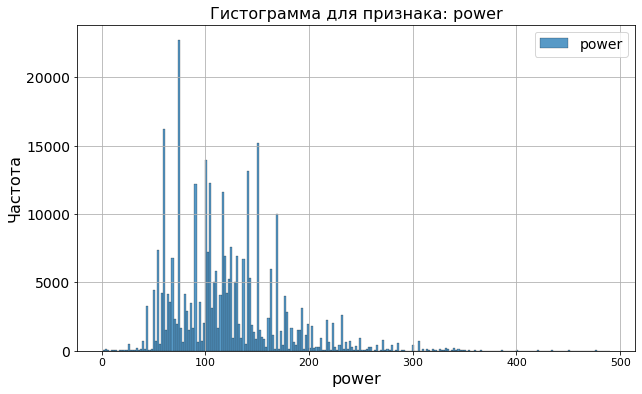

In [89]:
hist_plot_graph("power")

Нулевые значения отсутствуют:

In [90]:
df_autos['power'].isna().sum()

0

#### `kilometer`

Проверим пробег машин указанный пользователями в объявлениях.

Посмтроим диаграмму размаха:

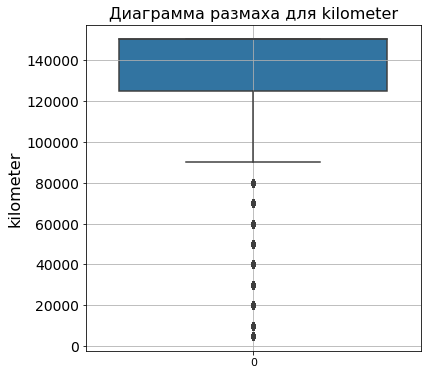

In [91]:
box_plot_graph('kilometer')

И гистограмму:

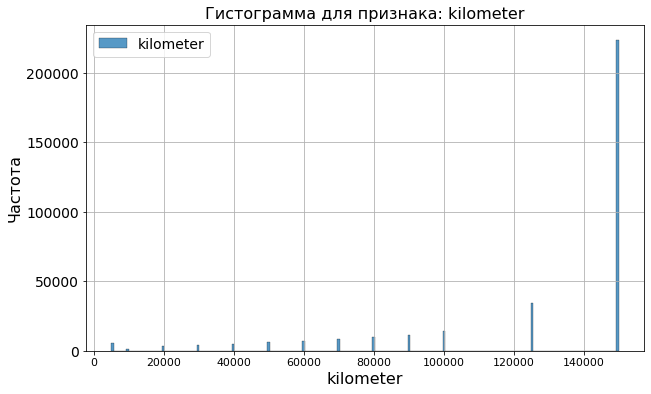

In [92]:
hist_plot_graph('kilometer')

Похоже, мы имеем дело с количественным дискретным признаком.

Проверим это используя `unique()`:

In [93]:
#уникальные значения столбца 'kilometer'
df_autos['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

Всё верно. В данном наборе данных пробег - количественный дискретный признак. Заданы адекватные значения, корректировка не требуется.

#### `postal_code`

Почтовый индекс в данном случае практически невозможно проверить, так как мы не знаем с каким регионом имеем дело, какое количество цифр должно быть указано. 

Для наглядности выведем гистограмму:

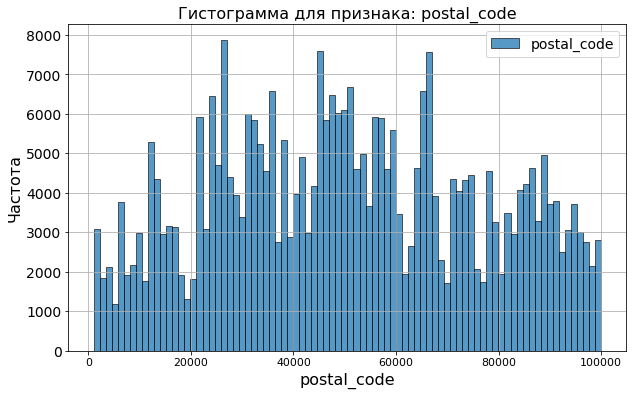

In [94]:
hist_plot_graph('postal_code')

Распределение значений плотное, довольно равномерное, без выборосов в большую или меньшую сторону, поэтому оставим как есть. 

Регион может повлиять на цену.

#### `price`

Итак, целевой признак - цена. Изучим какие ответы в нашем распоряжении.

Построим ящик с усами для целевого признака:

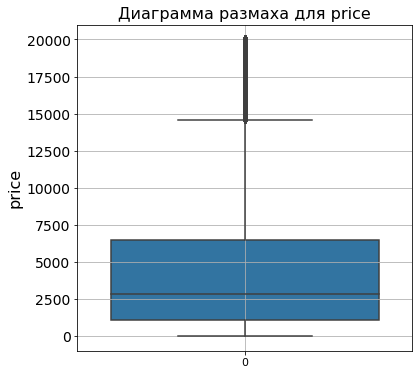

In [95]:
box_plot_graph('price')

И гистограмму:

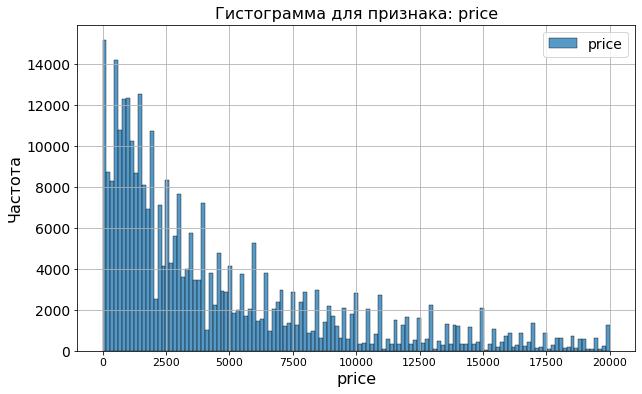

In [96]:
hist_plot_graph('price')

Ознакомимся с характеристикой выборки:

In [97]:
#характеристика выборки столбца 'price'
df_autos['price'].describe()

count    334152.000000
mean       4503.412411
std        4555.934452
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Распределение стоимости больше напоминает распределние Пуассона, а не нормальное. Это объяснимо: большинство автомобилей укладываются в стоимость **0-6500 у.е.** (75%). 

Нулевые значения в данном случае отбрасывать не будем, потому что это могут быть, например, машины на запчасти. Поэтому оставим целевой признак как есть без внешнего вмешательства.

### Проверка непрерывных переменных на мультиколлинеарность

Проверим колличественные признаки на мультиколлинеарность с использованием диаграммы рассеяния:

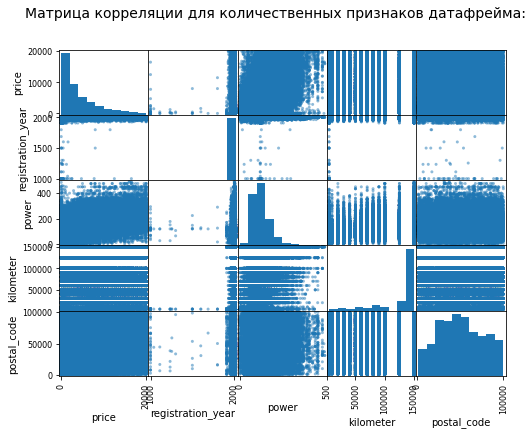

CPU times: user 21.3 s, sys: 35.2 ms, total: 21.3 s
Wall time: 21.3 s


In [98]:
%%time
pd.plotting.scatter_matrix(df_autos[['price',
                                     'registration_year', 
                                     'power',
                                     'kilometer', 
                                     'postal_code']],
                           figsize=(8, 6))
plt.suptitle('Матрица корреляции для количественных признаков датафрейма:', fontsize=14)
plt.show()

Визуализируем коэффициент корреляции Пирсона с помощью тепловой карты:

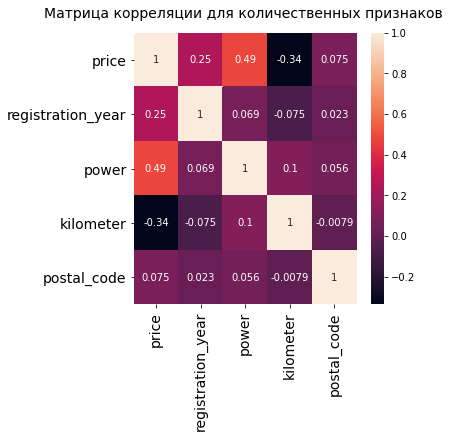

CPU times: user 345 ms, sys: 75.8 ms, total: 421 ms
Wall time: 420 ms


In [99]:
%%time

plt.figure(figsize=(5,5))

sns.heatmap(df_autos[['price',
                      'registration_year', 
                      'power',
                      'kilometer',
                      'postal_code']]
            .corr(),
            annot=True)

#название графика
plt.title('Матрица корреляции для количественных признаков ', 
          fontsize=14, 
          loc='center',
          pad=15)
#задаём размер значений на оси абсцисс и на оси ординат
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Умеренная положительная зависимость наблюдается между `price` и `power`, что вполне объяснимо: чем больше л.с., тем выше цена. 

Также мы видим отрицательную зависимость между ценой и пробегом - это тоже подтверждение реальности. Но она не такая сильная. Действительно, иногда с увеличением пробега автомобиль не так быстро теряет свою цену.

Важно, что нет мультиколлинеарности признаков между собой, значит моделям будет проще обучиться.

### Вывод

Обнаружены проблемы, которые следует учесть в дальнейшем для работы модели машинного обучения. Большинство из нижеприведенных проблем можно избежать, если переработать ввод данных пользователем в анкету на сайте.

В результате предобработки данных:
- пропуски в категориальных признаках (заполнены `unknown`)
- тип топлива задан двусмысленно, принято решение оставить как есть
- дата регистрации во многих случаях превышает дату выгрузки объявления (такие объекты удалены из рассмотрения)
- есть объекты с аномально большой мощностью двигателя (удалены из рассмотрения)
- около 10% объектов имеют мощность двигателя `0`, нулевая мощность заменена на среднюю для модели
- проанализированы все количественные и категориальные признаки


Повтрим, что многих ошибок можно избежать, если изменить форму заполнения анкеты на сайте.


## Обучение моделей

### Подготовка данных

#### Кодирование категориальных признаков (не для CatBoost)

Так как нам предстоит использовать не только CatBoost, то сделаем подготовку данных.

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования, или отображения (*англ. One-Hot Encoding, OHE*). 

Для прямого кодирования воспользуемся функцией `pd.get_dummies()` библиотеки `pandas`.

Чтобы не попасть в **дамми-ловушку** (ловушку фиктивных признаков) зададим параметр `drop_first=True`:

In [100]:
# преобразуем категориальные признаки в численные с помощью техники прямого кодирования
df_autos_ohe = pd.get_dummies(df_autos, drop_first=True)

Ознакомимся с результатом:

In [101]:
df_autos_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334152 entries, 0 to 334151
Columns: 317 entries, date_crawled to not_repaired_yes
dtypes: datetime64[ns](3), float64(1), int64(5), uint8(308)
memory usage: 131.7 MB


#### Разбивка данных на выборки (не для CatBoost)

Разобъём исходную выборку на обучающую, валидационную и тестовую в соотношении (3:1:1): 

|Выборка |Процент от количества объектов исходной выборки|
|:-----|:----:|
|Обучающая|60%|
|Валидационная|20%|
|Тестовая|20%|



Отложим тестовую выборку (20%), в обучающей оставим 80% исходного датасета (чтобы в дальнейшем выделить валидационную).

Используем `train_test_split` из модуля `sklearn.model_selection`. Разбивку произведём псевдослучайным образом, задав параметр `random_state` равным `12345`.

Всё сделаем аналогичным образом, но разбивку передадим **`df_autos_ohe`**:

In [102]:
# первый шаг разбивки - откладываем тестовую выборку, в обучающей оставляем 80%, 
#чтобы затем из неё выделить валидационную
df_train, df_test = train_test_split(df_autos_ohe, 
                                     test_size=0.20, 
                                     random_state=12345) 

Из обучающей выборки выделим валидационную. 20% от 80% это 1/4, или 25% от 100%:

In [103]:
# Второй шаг разбивки - выделяем из 80% оставшихся процентов обучающую и валидационную выборки.
# В обучающей оставляем 60% из 80%, в валидационной 20% из 80%, то есть 1/4, или 25% из 100%
df_train, df_valid = train_test_split(df_train,
                                      test_size=0.25, 
                                      random_state=12345) 

Проверим результат разбивки: количество строк в трех получившихся датафреймах в сумме должно быть равно исходному количеству объектов.

Для визуального ознакомления выведем количество объектов и признаков в каждой из выборок:

In [104]:
#количество объектов в исходной выборке
df_autos_ohe.shape

(334152, 317)

In [105]:
#количество объектов и признаков в тестовой выборке
df_test.shape

(66831, 317)

In [106]:
#количество объектов и признаков в обучающей выборке
df_train.shape

(200490, 317)

In [107]:
#количество объектов и признаков в валидационной выборке
df_valid.shape

(66831, 317)

Просуммируем количество объектов в каждой из выборок:

In [108]:
# суммарное количество объектов в трех выборках
df_test.shape[0]+df_train.shape[0]+df_valid.shape[0]

334152

Очевидно, что разбивка на выборки выполнена успешно: котрольная сумма сходится.

#### Тестовый, обучающий и валидационный наборы данных

Сохраним обучающий, тестовый и валидационный наборы данных в переменных `features` (признаки) и `target` (целевой признак).

Для этого создадим переменные для **признаков и целевого признака**. 

Сделаем это с использованием цикла по выборкам:

In [109]:
#цикл по названию выборки
for name in ['test','train','valid']:
    
    #признаки для текущей выборки
    locals()['features_'+name] = (locals()['df_'+name]
                                  .drop(['price',
                                         'date_crawled', 
                                         'registration_month', 
                                         'date_created', 
                                         'last_seen'], 
                                        axis=1))
    
    #вывод на экран именени переменной для таблицы признаков текущей выборки и её размерности
    print('features_'+name, 'shape:', 
          locals()['features_'+name].shape)
    
    #целевой признак для текущей выборки
    locals()['target_'+name] = (locals()['df_'+name]
                                ['price'])
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('target_'+name, 'shape:',
          locals()['target_'+name].shape)
    
    print()

features_test shape: (66831, 312)
target_test shape: (66831,)

features_train shape: (200490, 312)
target_train shape: (200490,)

features_valid shape: (66831, 312)
target_valid shape: (66831,)



#### Масштабирование численных признаков

Создадим список всех численных признаков:

In [110]:
#список численных признаков
numeric = ['registration_year',
           'power', 
           'kilometer', 
           'postal_code']

Выполним масштабирование численных признаков - приведём их к одному масштабу, так как они все важны.

Воспользуемся структурой библиотеки `sklearn` для *стандартизации данных* — **`StandardScaler`** (от англ. «преобразователь масштаба методом стандартизации»). Он находится в модуле `sklearn.preprocessing`.

Создадим объект этой структуры:

In [111]:
#создаём объект структуры StandardScaler
scaler = StandardScaler()

И настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии:

In [112]:
#настройка объекта на обучающих данных
scaler.fit(features_train[numeric]) 

StandardScaler()

Преобразуем обучающую, валидационную и тестовую выборки функцией `transform()`: 

In [113]:
#преобразование обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])

#преобразование валидационной выборки
features_valid[numeric] = scaler.transform(features_valid[numeric]) 

#преобразование тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric]) 

Ознакомимся с результатом, выведем первые 5 строк численных признаков `features_train` после масштабирования:

In [114]:
#вывод первых 5 строк численных признаков после масштабирования
features_train[numeric].head()

,registration_year,power,kilometer,postal_code
116223,-0.470709,-0.572949,0.579686,-0.767310
159590,-0.163313,-1.148036,-0.079372,-0.018821
66460,0.451478,0.960615,0.579686,-1.097396
215778,-0.317011,-0.381254,0.579686,-0.058968
146402,0.835723,0.213003,-2.056549,-0.580216


И ознакомимся с характеристиками выборки численных признаков после масштабирования:

In [115]:
#характеристики выборки численных признаков после масштабирования
features_train[numeric].describe()

,registration_year,power,kilometer,postal_code
count,2.004900e+05,2.004900e+05,2.004900e+05,2.004900e+05
mean,-3.688273e-15,4.383966e-17,-5.837019e-17,6.393432e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-7.701225e+01,-2.279039e+00,-3.242855e+00,-1.921644e+00
25%,-2.401620e-01,-8.221532e-01,-7.937239e-02,-7.935832e-01
50%,6.723372e-02,-1.128798e-01,5.796864e-01,-4.462963e-02
75%,3.746295e-01,5.197155e-01,5.796864e-01,7.985680e-01
max,1.066270e+00,7.075702e+00,5.796864e-01,1.912097e+00


Очевидно, что в результате масштабирования у численных признаков одинаковое стандартное отклонение.

### Модель линейной регрессии

Создадим модель линейной регрессии:

In [116]:
#модель логистической регрессии
best_model_lr = LinearRegression()

Обучим модель на обучающей выборке:

In [117]:
%%time
#обучение модели на тренировочной выборке
best_model_lr.fit(features_train, target_train)

CPU times: user 16 s, sys: 8.37 s, total: 24.4 s
Wall time: 24.4 s


LinearRegression()

Сохраним время обучения:

In [118]:
fit_time_lr_s = 17.6

Сделаем предсказания на валидационной, измерим время предсказаний:

In [119]:
%%time

#делаем предсказания на валидационной выборке
predict_lr_valid =best_model_lr.predict(features_valid)

CPU times: user 63.4 ms, sys: 71.1 ms, total: 134 ms
Wall time: 106 ms


In [120]:
predict_time_lr_ms = 124

Вычислим $RMSE$ на валидационной выборке (`squared=False` задано, чтобы вычислять $RMSE$ вместо $MSE$):

In [121]:
#вычисляем RMSE на валидационной выборке
rmse_lr_valid = mean_squared_error(target_valid, predict_lr_valid, squared=False)

rmse_lr_valid

2894.106487545729

Учитывая характеристику выборки целевого признака на валидационной выборке:

In [122]:
#характеристика выборки целевого признака на валидационной выборке
target_valid.describe()

count    66831.000000
mean      4501.312026
std       4541.761899
min          0.000000
25%       1100.000000
50%       2800.000000
75%       6500.000000
max      20000.000000
Name: price, dtype: float64

Результат работы модели отличается высокой скоростью предсказания (**187 мс**), но довольно высокой ошибкой RMSE, равной примерно 64% от среднего значения:

In [123]:
rmse_rel_mean_lr = round(rmse_lr_valid/target_valid.mean()*100,2)

rmse_rel_mean_lr

64.29

### Модель `CatBoostRegressor`

Так как для `CatBoostRegressor` не требуется кодирование категориальных признаков, то придётся сделать разбивку на выборки повторно, используя подготовленный `df_autos`:

In [124]:
# первый шаг разбивки - откладываем тестовую выборку, в обучающей оставляем 80%, 
#чтобы затем из неё выделить валидационную
df_cbr_train, df_cbr_test = train_test_split(df_autos, 
                                             test_size=0.20, 
                                             random_state=12345) 

Из обучающей выборки выделим валидационную. 

20% от 80% это 1/4, или 25% от 100%:

In [125]:
# Второй шаг разбивки - выделяем из 80% оставшихся процентов обучающую и валидационную выборки.
# В обучающей оставляем 60% из 80%, в валидационной 20% из 80%, то есть 1/4, или 25% из 100%
df_cbr_train, df_cbr_valid = train_test_split(df_cbr_train,
                                              test_size=0.25, 
                                              random_state=12345) 

Разобъём выборки на тестовый, обучающий, валидационный наборы данных:

In [126]:
#цикл по названию выборки
for name in ['test','train','valid']:
    
    #признаки для текущей выборки
    locals()['X_'+name] = (locals()['df_cbr_'+name]
                                  .drop(['price',
                                         'date_crawled', 
                                         'registration_month', 
                                         'date_created', 
                                         'last_seen'], 
                                        axis=1))
    
    #вывод на экран именени переменной для таблицы признаков текущей выборки и её размерности
    print('X_'+name, 'shape:', 
          locals()['X_'+name].shape)
    
    #целевой признак для текущей выборки
    locals()['y_'+name] = (locals()['df_cbr_'+name]
                                ['price'])
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('y_'+name, 'shape:',
          locals()['y_'+name].shape)
    
    print()

X_test shape: (66831, 10)
y_test shape: (66831,)

X_train shape: (200490, 10)
y_train shape: (200490,)

X_valid shape: (66831, 10)
y_valid shape: (66831,)



Перечень признаков, которые мы включили в обучение модели:

In [127]:
#признаки для обучения модели
X_train.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'not_repaired', 'postal_code'],
      dtype='object')

Укажем какие из них являются категориальными:

In [128]:
cf = ['vehicle_type', 
      'gearbox',
      'model',
      'fuel_type', 
      'brand', 
      'not_repaired']

Создадим модель градиентного бустинга, функция потерь будет задана- `RMSE`:

In [129]:
model_cbr = CatBoostRegressor(loss_function='RMSE',
                              cat_features=cf,
                              verbose=25)

Введём гиперпараметры, которые будем изменять:

- `max_depth` - максимальная глубина дерева,
- `n_estimators` - количество итераций (максимальное количество деревьев, которое можно построить при решении задач машинного обучения),
- `learning_rate` - скорость обучения.

В связи с тем, что модель градиентного бустинга может обучаться долго, а также учитывая, что данный кейс - учебный, рассмотрим лишь несколько параметров, без детального перебора в широком спектре возможных значений.

In [130]:
grid_parameters_cbr = {'max_depth': [5,10],         #Depth of the tree.
                        'n_estimators':[25,100],    #The maximum number of trees that can be 
                                                    #built when solving machine learning problems.
                        'learning_rate':[0.1,0.2]}  #The learning rate. Used for reducing the gradient step

Воспользуемся `GridSearchCV` для подбора оптимальных параметров:

In [131]:
grid_search_cbr = GridSearchCV(model_cbr,
                               grid_parameters_cbr,
                               cv=3,
                               verbose=False)

Выполним поиск оптимальных гиперпараметров:

In [132]:
grid_search_cbr.fit(X_train,y_train)

0:	learn: 4274.8349813	total: 104ms	remaining: 2.49s
24:	learn: 2238.0593821	total: 1.18s	remaining: 0us
0:	learn: 4287.5748635	total: 50.4ms	remaining: 1.21s
24:	learn: 2237.4801011	total: 1.11s	remaining: 0us
0:	learn: 4282.2987691	total: 96.4ms	remaining: 2.31s
24:	learn: 2235.4863891	total: 1.13s	remaining: 0us
0:	learn: 4274.8349813	total: 49.7ms	remaining: 4.92s
25:	learn: 2219.2128684	total: 1.14s	remaining: 3.26s
50:	learn: 2020.6328636	total: 2.15s	remaining: 2.07s
75:	learn: 1953.6388069	total: 3.22s	remaining: 1.02s
99:	learn: 1913.2713256	total: 4.22s	remaining: 0us
0:	learn: 4287.5748635	total: 49.8ms	remaining: 4.93s
25:	learn: 2218.4324779	total: 1.1s	remaining: 3.15s
50:	learn: 2019.6838546	total: 2.16s	remaining: 2.08s
75:	learn: 1948.2732625	total: 3.22s	remaining: 1.01s
99:	learn: 1909.2376770	total: 4.19s	remaining: 0us
0:	learn: 4282.2987691	total: 48.6ms	remaining: 4.82s
25:	learn: 2216.9273641	total: 1.09s	remaining: 3.1s
50:	learn: 2021.2109964	total: 2.16s	rema

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2522b28a90>,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 10],
                         'n_estimators': [25, 100]},
             verbose=False)

Выведем лучшие обнаруженные параметры:

In [133]:
grid_search_cbr.best_params_

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}

Сохраним соответствующую лучшую модель:

In [134]:
best_model_cbr = CatBoostRegressor(learning_rate=0.2, 
                                   max_depth=10, 
                                   n_estimators=100,
                                   cat_features=cf,
                                   verbose=25)

Измерим время обучения лучшей модели на валидационной выборке:

In [135]:
%%time
best_model_cbr.fit(X_train,y_train)

0:	learn: 3932.4077085	total: 154ms	remaining: 15.3s
25:	learn: 1823.7001474	total: 3.12s	remaining: 8.87s
50:	learn: 1722.2214408	total: 6.14s	remaining: 5.9s
75:	learn: 1662.5267844	total: 10.2s	remaining: 3.23s
99:	learn: 1624.1447454	total: 13.1s	remaining: 0us
CPU times: user 12.3 s, sys: 127 ms, total: 12.5 s
Wall time: 13.7 s


In [136]:
fit_time_cbr_s = 14.2

Самое важное для внедрения модели (точнее один из самых важных критериев) - время предсказания:

In [137]:
%%time

#делаем предсказания на валидационной выборке
predict_cbr_valid = best_model_cbr.predict(X_valid)

CPU times: user 85.1 ms, sys: 7.54 ms, total: 92.7 ms
Wall time: 93.7 ms


In [138]:
predict_time_cbr_ms = 104

Вычислим $RMSE$ на валидационной выборке (`squared=False` задано, чтобы вычислять $RMSE$ вместо $MSE$):

In [139]:
#вычисляем RMSE на валидационной выборке
rmse_cbr_valid = mean_squared_error(y_valid, 
                                    predict_cbr_valid, 
                                    squared=False)

rmse_cbr_valid

1725.608244275643

В процентах от среднего:

In [140]:
rmse_rel_mean_cbr = round(rmse_cbr_valid/y_valid.mean()*100,2)

rmse_rel_mean_cbr

38.34

Результат значительно улучшился в сравнении с линейной регрессией.

### Библиотека `LGBM`

Создадим модель градиентного бустинга для задачи регрессии из библиотеки LGBM:

In [141]:
# define the model
model_lgbm = LGBMRegressor()

Введём гиперпараметры, которые будем исследовать (аланогичные `CatBoostRegersor`): 

In [142]:
grid_parameters_lgbm = {'max_depth': [5,10],       #Depth of the tree.
                        'n_estimators':[25,100],   #The maximum number of trees that can be 
                                                   #built when solving machine learning problems.
                        'learning_rate':[0.1,0.2]} #The learning rate. Used for reducing the gradient step

Воспользуемся `GridSearchCV` для подбора оптимальных параметров:

In [143]:
grid_search_lgbm = GridSearchCV(model_lgbm,
                               grid_parameters_lgbm,
                                cv=3,
                                verbose=False)

Выполним поиск оптимальных гиперпараметров на обучающем наборе данных. Передавать будем данные, для которых выполнено кодирование категориальных признаков и масштабирование количественных:

In [144]:
grid_search_lgbm.fit(features_train,target_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 10],
                         'n_estimators': [25, 100]},
             verbose=False)

Выведем лучшие параметры:

In [145]:
grid_search_lgbm.best_params_

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}

Сохраним лучшую модель:

In [146]:
best_model_lgbm = LGBMRegressor(learning_rate=0.2, 
                                max_depth=10, 
                                n_estimators=100)

Измерим время обучения лучшей модели на тренировочной выборке. Стоит отметить, что для LGBM мы используем наборы данных, подготвленные ранее для модели линейной регрессии.

In [147]:
%%time
best_model_lgbm.fit(features_train,target_train)

CPU times: user 5.89 s, sys: 287 ms, total: 6.17 s
Wall time: 6.2 s


LGBMRegressor(learning_rate=0.2, max_depth=10)

In [148]:
fit_time_lgbm_s = 6.06

Измерим время предсказания на валидационной выборке (от запуска к запуску время может отличаться, но масштаб сохраняется):

In [149]:
%%time

#делаем предсказания на валидационной выборке
predict_lgbm_valid = best_model_lgbm.predict(features_valid)

CPU times: user 591 ms, sys: 89.2 ms, total: 680 ms
Wall time: 684 ms


In [150]:
predict_time_lgbm_ms = 701

Вычислим $RMSE$ на валидационной выборке (`squared=False` задано, чтобы вычислять $RMSE$ вместо $MSE$):

In [151]:
#вычисляем RMSE на валидационной выборке
rmse_lgbm_valid = mean_squared_error(target_valid, 
                                     predict_lgbm_valid, 
                                     squared=False)

rmse_lgbm_valid

1746.3413067822653

В процентах от среднего:

In [152]:
rmse_rel_mean_lgbm = round(rmse_lgbm_valid/target_valid.mean()*100,2)

rmse_rel_mean_lgbm

38.8

Результат улучшился в сравнении с линейной регрессии.

## Анализ моделей

Так как мы отложили тестовую выборку, то проверим качество моделей на ней.

Для линейной регрессии:

In [153]:
predict_lr_test = best_model_lr.predict(features_test)

rmse_lr_test = mean_squared_error(target_test, 
                                  predict_lr_test, 
                                  squared=False)

Для CatBoostRegressor:

In [154]:
predict_cbr_test = best_model_cbr.predict(X_test)

rmse_cbr_test = mean_squared_error(y_test, 
                                    predict_cbr_test, 
                                    squared=False)

Для LGBM:

In [155]:
predict_lgbm_test = best_model_lgbm.predict(features_test)

rmse_lgbm_test = mean_squared_error(target_test, 
                                    predict_lgbm_test, 
                                    squared=False)

Проанализируем скорость работы и качество моделей с помощью сводной таблицы:

In [156]:
table = pd.DataFrame({'Модель': ['LinearRegression', 'CatBoostRegression', 'LGBMRegressor'],
                      'Время обучения, с':[fit_time_lr_s, fit_time_cbr_s, fit_time_lgbm_s],
                      'Время предсказания, мс': [predict_time_lr_ms, predict_time_cbr_ms, predict_time_lgbm_ms],
                      'RMSE_valid, у.е.': [rmse_lr_valid, rmse_cbr_valid, rmse_lgbm_valid],
                      'RMSE_valid/mean(), %':[rmse_rel_mean_lr, rmse_rel_mean_cbr, rmse_rel_mean_lgbm],
                      'RMSE_test': [rmse_lr_test,rmse_cbr_test,rmse_lgbm_test]})

table

,Модель,"Время обучения, с","Время предсказания, мс","RMSE_valid, у.е.","RMSE_valid/mean(), %",RMSE_test
0,LinearRegression,17.60,124,2894.106488,64.29,2885.002154
1,CatBoostRegression,14.20,104,1725.608244,38.34,1723.966818
2,LGBMRegressor,6.06,701,1746.341307,38.80,1742.507770


**Переходим к выводам**:

- При перезапуске тетради время немного изменяется, но общая тенденция сохраняется. 
- На тестовой выборке результат метрики всех рассматриваемых моделей немного улучшился.
- Линейная регрессия - дольше всех обучается, хуже всех предсказывает, но зато делает это достаточно быстро.
- CatBoost и LGBM оказались значительно лучше линейной регрессии по метрике качества.
- Очевидно, что при одинаковых исходных гиперпараметрах модель CatBoost оказалась лучше по метрике качества и времени предсказаний. 
- Да, CatBoost дольше обучается, но обучаем модель мы 1 раз, а используем многократно.

## Общий вывод

1. На стадии укрупнённого знакомства с данными мы выяснили:

    - Нам доступна информация для примерно *354,4 тысяч объектов* - объявлений о продаже автомобилей с пробегом. 
    - В каждом объявлении инфомрация о 16 признаках, в некоторых из них имеются пропущенные значения. 
    - В признаках с датой и временем некорректный формат данных, формат данных изменили, но для обучения модели эти признаки не применяли, так как сочли их не важными.
    - Отсуствует информация о количестве фотографий, этот признак придётся удалить из рассмотрения.
    - *Предварительно можно утверждать, что данных для исследования достаточно*.
    
    
2. В результате предобработки данных обнаружены проблемы, которые следует учесть в дальнейшем для работы модели машинного обучения. Большинство из нижеприведенных проблем можно было избежать, если переработать ввод данных пользователем в анкету на сайте.

    - Пропуски в категориальных признаках (заполнены `unknown`)
    - Тип топлива задан двусмысленно, принято решение оставить как есть
    - Дата регистрации во многих случаях превышает дату выгрузки объявления (такие объекты удалены из рассмотрения)
    - Есть объекты с аномально большой мощностью двигателя (удалены из рассмотрения)
    - Около 10% объектов имеют мощность двигателя `0`, нулевая мощность заменена на среднюю для модели
    - Проанализированы все количественные и категориальные признаки
    

3. В ходе обучения обучения моделей:

    - Для рассмотрения выбраны 3 модели - линейная регрессия, CatBoostRegressor, LGBMRegressor
    - Выполнено кодирование категориальных признаков, масштабирование количественных для примения при обучении и тестировании модели линейной регрессии и градиентного бустинга библиотеки LGBM
    - Данные разбиты на тестовый, обучающий и валидационный наборы
    - Выполнен подбор гиперпараметров, измерение времени обучения и предсказания лучших моделей, а также контроль метрик.


4. Анализ полученных результатов:
    - На тестовой выборке результат метрики всех рассматриваемых моделей немного улучшился.
    - Линейная регрессия - дольше всех обучается, хуже всех предсказывает, но зато делает это достаточно быстро.
    - CatBoost и LGBM оказались значительно лучше линейной регрессии по метрике качества.
    - Очевидно, что при одинаковых исходных гиперпараметрах модель CatBoost оказалась лучше по метрике качества и времени предсказаний. 
    - Да, CatBoost дольше обучается, но обучаем модель мы 1 раз, а используем многократно.

Результаты учебного проекта показывают, что `CatBoostRegressor` и другие библиотеки градиентного бустинга могут эффективно применяться для предсказания даже задач регрессии. Но чем точнее результат мы хотим получить, тем больше времени и ресурсов потребуется для его достижения.